In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import warnings

# Suppress specific UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
def load_mnist_dataset(root="data", train=True, download=True):
    """
    Load the MNIST dataset.

    Args:
        root (str): Root directory of the dataset.
        train (bool): If True, loads the training dataset; otherwise, loads the test dataset.
        download (bool): If True, downloads the dataset if it is not already available.

    Returns:
        torchvision.datasets.MNIST: The MNIST dataset.
    """
    return datasets.MNIST(
        root=root,
        train=train,
        transform=ToTensor(),
        download=download,
    )

train_data = load_mnist_dataset(train=True)
test_data = load_mnist_dataset(train=False)

In [3]:
print(f"Size of the test data is {test_data.data.shape}")
print(f"Size of the train data is {train_data.data.shape}")

Size of the test data is torch.Size([10000, 28, 28])
Size of the train data is torch.Size([60000, 28, 28])


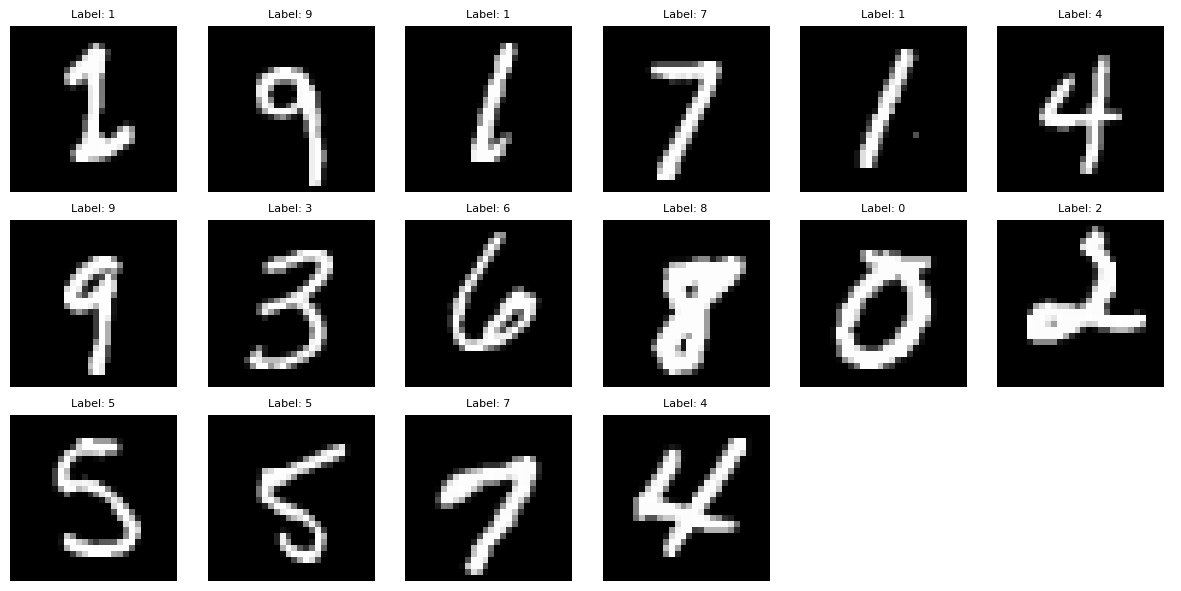

In [4]:
import random as rn
import matplotlib.pyplot as plt
import math


def visualize_random_images(dataset, num_images=10, images_per_row=5) -> None:
    """
    Displays a set of random images from the dataset in a grid format.

    Parameters:
    dataset (torch.utils.data.Dataset): The dataset to sample images from.
    num_images (int): The total number of images to display (default: 10).
    images_per_row (int): Number of images per row in the grid (default: 5).

    Returns:
    None
    """

    dataset_size = len(dataset)
    random_idx = [rn.randint(0, dataset_size - 1) for _ in range(num_images)]

    # calculating the needed number of rows
    num_rows = math.ceil(num_images / images_per_row)

    fig, axes = plt.subplots(
        num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2)
    )

    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, idx in enumerate(random_idx):
        data, target = dataset[idx]
        image = data.squeeze().numpy()  # Convert tensor to numpy format

        # Display image
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(f"Label: {target}", fontsize=8)
        axes[i].axis("off")

    # Hide any unused subplot areas
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


visualize_random_images(train_data, num_images=16, images_per_row=6)

In [5]:
from torch.utils.data import DataLoader

loaders = {
    "train": DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    "test": DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1),
}

print(loaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x799df2331550>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x799df1fcaad0>}


In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(
            1, 10, kernel_size=5
        )  # Conv layer 1: 1 input channel → 10 output channels
        self.conv2 = nn.Conv2d(
            10, 20, kernel_size=5
        )  # Conv layer 2: 10 input channels → 20 output channels
        self.conv2_drop = nn.Dropout2d()  # Dropout layer to reduce overfitting
        self.fc1 = nn.Linear(
            320, 50
        )  # Fully connected layer: 320 input → 50 output neurons
        self.fc2 = nn.Linear(
            50, 10
        )  # Fully connected layer: 50 input → 10 output (10 classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # Conv1 → ReLU → Max Pooling
        x = F.relu(
            F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)
        )  # Conv2 → Dropout → ReLU → Max Pooling
        x = x.view(-1, 320)  # Flatten feature maps into a 1D vector
        x = F.relu(self.fc1(x))  # Fully Connected Layer 1 + ReLU
        x = F.dropout(x, training=self.training)  # Dropout applied before final layer
        x = self.fc2(x)  # Fully Connected Layer 2 (final output layer)

        return F.softmax(x) 

| **Layer**                          | **Operation**     | **Shape Transformation** (for MNIST: `(1, 28, 28)`) |
|-------------------------------------|------------------|-----------------------------------------------|
| **Conv2D (1 → 10, 5×5 kernel)**     | Convolution      | `(1, 28, 28) → (10, 24, 24)`                 |
| **Max Pooling (2×2)**               | Downsampling     | `(10, 24, 24) → (10, 12, 12)`                |
| **Conv2D (10 → 20, 5×5 kernel)**    | Convolution      | `(10, 12, 12) → (20, 8, 8)`                  |
| **Dropout**                         | Regularization   | No shape change                              |
| **Max Pooling (2×2)**               | Downsampling     | `(20, 8, 8) → (20, 4, 4)`                    |
| **Flatten**                         | Reshape          | `(20, 4, 4) → (320,)`                        |
| **Fully Connected (320 → 50)**      | Dense Layer      | `(320,) → (50,)`                             |
| **Dropout**                         | Regularization   | No shape change                              |
| **Fully Connected (50 → 10)**       | Output Layer     | `(50,) → (10,)`                              |

### 1. First Convolutional Layer
The first convolutional layer applies 10 convolutional filters, each of size $5 \times 5$, to the input image. Given that the input consists of a single grayscale image of dimensions $28 \times 28$, each of the 10 filters generates a separate feature map. Since no padding is applied, the spatial dimensions of the output feature maps are reduced as follows:  

$$
28 \times 28 \rightarrow 24 \times 24
$$

At this stage, the convolutional layer primarily captures low-level features such as edges and corners.



### 2. First Max Pooling Layer
A max pooling operation is performed with a $2 \times 2$ filter, selecting the maximum value from each $2 \times 2$ region. This results in a downsampling effect, reducing the spatial dimensions by half:

$$
24 \times 24 \rightarrow 12 \times 12
$$

The purpose of max pooling is threefold:
- Reduction of computational complexity by decreasing the number of activations.
- Extraction of dominant features, ensuring the most relevant spatial information is retained.
- Mitigation of overfitting by enforcing translational invariance.



### 3. Second Convolutional Layer
The second convolutional layer applies 20 convolutional filters of size $5 \times 5$ to the previous feature maps. Since there were 10 feature maps from the first layer, this layer now operates on these learned representations, capturing more complex hierarchical features such as textures and specific shapes. As in the first convolutional layer, the lack of padding results in a reduction of spatial dimensions:

$$
12 \times 12 \rightarrow 8 \times 8
$$



### 4. Dropout Regularization
A dropout layer is applied to randomly disable a subset of neurons during training, thus preventing overfitting. While dropout has no effect on the shape of the feature maps, it improves generalization by reducing dependency on specific neurons and encouraging the network to learn more robust features.



### 5. Second Max Pooling Layer
Similar to the first max pooling layer, the second $2 \times 2$ max pooling operation is applied to the feature maps, further reducing the spatial dimensions:

$$
8 \times 8 \rightarrow 4 \times 4
$$




### 6. Flattening Operation
Before passing the learned representations to fully connected layers, the feature maps are flattened into a one-dimensional vector. Given that there are 20 feature maps of size $4 \times 4$, the resulting vector has the following shape:

$$
(20, 4, 4) \rightarrow (320,)
$$



### 7. First Fully Connected Layer
A fully connected layer applies a linear transformation to the flattened vector, mapping it to a feature representation of dimension $50$:

$$
(320,) \rightarrow (50,)
$$




### 8. Dropout Regularization
A second dropout layer is introduced to further enhance generalization and prevent overfitting. Again, this does not affect the shape of the data but improves robustness.



### 9. Output Layer and Classification
The final layer of the network is a fully connected layer that outputs 10 values, each corresponding to a digit class (0-9):

$$
(50,) \rightarrow (10,)
$$

These 10 values represent the raw logits, which are subsequently passed through a softmax activation function to produce class probabilities.



## Softmax Activation Function
The softmax function is applied to the output layer to convert the raw scores ($z_i$) into probabilities ($p_i$), ensuring that they sum to 1. The softmax function is defined as:

$$
p_i = \frac{e^{z_i}}{\sum_{j=1}^{10} e^{z_j}}
$$

where:
- $ z_i $ represents the raw output (logit) for class $ i $,
- $ e^{z_i} $ exponentiates each logit, ensuring non-negative values,
- The denominator normalizes the values so they sum to 1.

This transformation ensures that the network’s final output can be interpreted as a probability distribution over the 10 digit classes. The predicted class is determined by selecting the index with the highest probability.

# Training The Model

We check whether `cuda` is available. If not, we will move the model to `cpu`

In [7]:
import torch

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizer, and loss function
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Print the selected device
print(f"The selected device is: {device}")

The selected device is: cpu


In [8]:
import torch.nn as nn
import torch.optim as optim


def train(epoch):
    """Train the model for one epoch."""
    model.train()
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print(
                f"Train Epoch: {epoch} "
                f"[{batch_idx * len(data)} / {len(loaders['train'].dataset)} "
                f"({100. * batch_idx / len(loaders['train']):.0f}%)]\t"
                f"Loss: {loss.item():.6f}"
            )


def test():
    """Evaluate the model on the test set."""
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / len(loaders['test'].dataset)
    
    test_loss /= len(loaders["test"].dataset)
    print(
        f"\nTest set: Average Loss: {test_loss:.4f}, "
        f"Accuracy: {correct / len(loaders['test'].dataset):.4f} "
        f"({100. * correct / len(loaders['test'].dataset):.0f}%)\n"
    )

    return accuracy

In [9]:
accuracy_over_time = []

for epoch in range(1, 11):
    train(epoch)
    accuracy_over_time.append(test())

print(accuracy_over_time)

Train Epoch: 1 [0 / 60000 (0%)]	Loss: 2.301069
Train Epoch: 1 [2000 / 60000 (3%)]	Loss: 2.280506
Train Epoch: 1 [4000 / 60000 (7%)]	Loss: 2.161815
Train Epoch: 1 [6000 / 60000 (10%)]	Loss: 1.988844
Train Epoch: 1 [8000 / 60000 (13%)]	Loss: 1.882539
Train Epoch: 1 [10000 / 60000 (17%)]	Loss: 1.819351
Train Epoch: 1 [12000 / 60000 (20%)]	Loss: 1.784205
Train Epoch: 1 [14000 / 60000 (23%)]	Loss: 1.719831
Train Epoch: 1 [16000 / 60000 (27%)]	Loss: 1.740459
Train Epoch: 1 [18000 / 60000 (30%)]	Loss: 1.706315
Train Epoch: 1 [20000 / 60000 (33%)]	Loss: 1.675503
Train Epoch: 1 [22000 / 60000 (37%)]	Loss: 1.705996
Train Epoch: 1 [24000 / 60000 (40%)]	Loss: 1.683515
Train Epoch: 1 [26000 / 60000 (43%)]	Loss: 1.640617
Train Epoch: 1 [28000 / 60000 (47%)]	Loss: 1.679279
Train Epoch: 1 [30000 / 60000 (50%)]	Loss: 1.633268
Train Epoch: 1 [32000 / 60000 (53%)]	Loss: 1.672240
Train Epoch: 1 [34000 / 60000 (57%)]	Loss: 1.610793
Train Epoch: 1 [36000 / 60000 (60%)]	Loss: 1.637498
Train Epoch: 1 [38000 /

# Evaluating the model Performance. Displaying instances.

In [10]:
import random as rn
import matplotlib.pyplot as plt
import math

model.eval()


def test_it(num_of_images: int) -> None:
    """Test the model on a random set of images and display predictions in a grid."""
    indices = [rn.randint(0, len(test_data) - 1) for _ in range(num_of_images)]
    
    images_per_row = 5  # Number of images in each row
    num_rows = math.ceil(num_of_images / images_per_row)  # Calculate required rows

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2))

    # Flatten axes array if there's more than one row
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, idx in enumerate(indices):
        data, target = test_data[idx]
        data = data.unsqueeze(0).to(device)

        output = model(data)
        prediction = output.argmax(dim=1).item()

        print(f'Image {idx}: Prediction={prediction}, Actual={target}')

        image = data.squeeze().cpu().numpy()

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Pred: {prediction}', fontsize=8)
        axes[i].axis('off')

    # Hide any unused subplots (if total images aren't exactly a multiple of images_per_row)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Image 4678: Prediction=7, Actual=7
Image 8435: Prediction=3, Actual=3
Image 6225: Prediction=2, Actual=2
Image 4009: Prediction=9, Actual=9
Image 6154: Prediction=8, Actual=8
Image 7692: Prediction=3, Actual=3
Image 18: Prediction=3, Actual=3
Image 3723: Prediction=0, Actual=9
Image 3826: Prediction=5, Actual=5
Image 1138: Prediction=2, Actual=2
Image 9412: Prediction=4, Actual=4
Image 9287: Prediction=9, Actual=9
Image 658: Prediction=7, Actual=7
Image 6867: Prediction=4, Actual=4
Image 723: Prediction=0, Actual=0
Image 799: Prediction=2, Actual=2
Image 9379: Prediction=2, Actual=2
Image 3418: Prediction=7, Actual=7
Image 2129: Prediction=8, Actual=9
Image 4748: Prediction=8, Actual=8


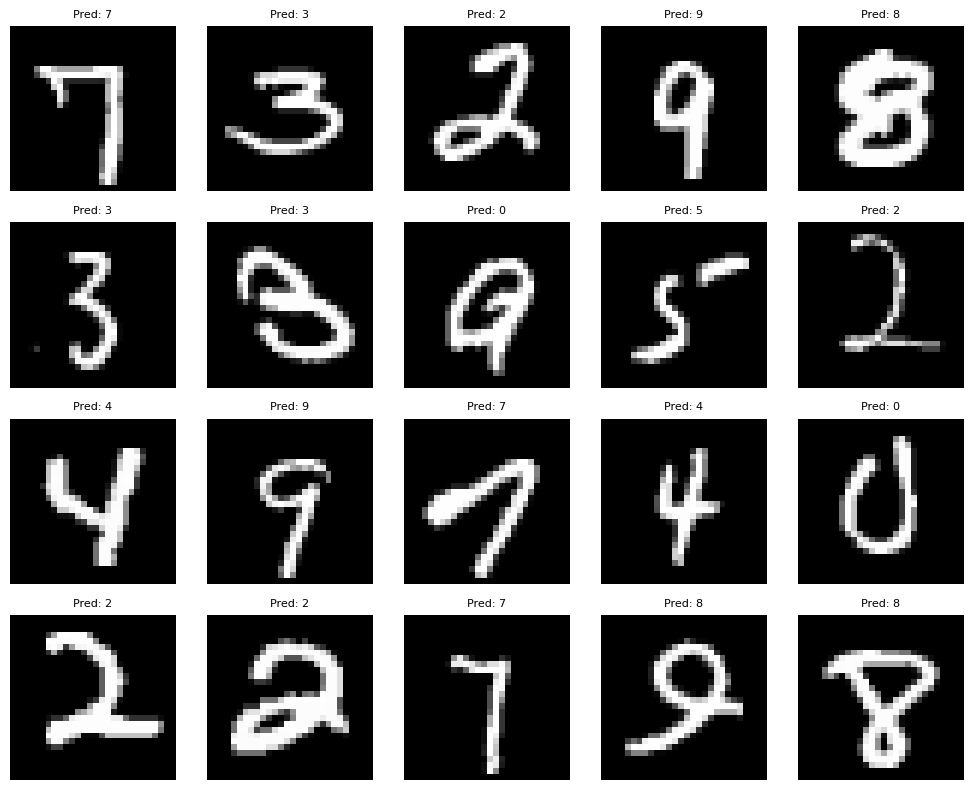

In [11]:
test_it(20)

# GUI

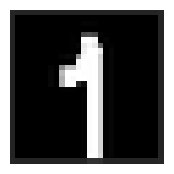

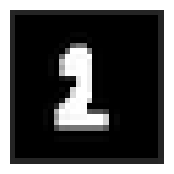

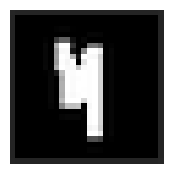

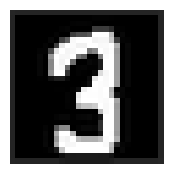

In [12]:
import tkinter as tk
from tkinter import Canvas, Button
import numpy as np
from PIL import Image, ImageDraw, ImageGrab
import torch
import matplotlib.pyplot as plt


class MNISTDigitRecognizer:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.root = tk.Tk()
        self.root.title("Digit Recognizer (PyTorch)")
        self.setup_ui()

    def setup_ui(self):
        """Set up the Tkinter UI."""
        # Canvas for drawing
        self.canvas_width, self.canvas_height = 28, 28
        self.canvas = Canvas(self.root, width=self.canvas_width, height=self.canvas_height, bg="white")
        self.canvas.pack()

        # Blank image to store the drawing
        self.image = Image.new("L", (self.canvas_width, self.canvas_height), 255)
        self.draw_obj = ImageDraw.Draw(self.image)

        # Buttons
        predict_button = Button(self.root, text="Predict", command=self.recognize_digit)
        predict_button.pack(side=tk.LEFT)

        clear_button = Button(self.root, text="Clear", command=self.clear_canvas)
        clear_button.pack(side=tk.RIGHT)

        # Label for prediction result
        self.result_label = tk.Label(self.root, text="Predicted Digit: ", font=("Arial", 16))
        self.result_label.pack()

        # Bind drawing function
        self.canvas.bind("<B1-Motion>", self.draw)

    def preprocess_image(self, image):
        """Preprocess the drawn image for prediction."""
        image = image.convert("L")
        image = image.resize((28, 28), Image.Resampling.LANCZOS)
        image = np.array(image, dtype=np.float32) / 255.0
        image = 1 - image
        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        return image_tensor

    def recognize_digit(self):
        """Predict the digit drawn on the canvas."""
        x = self.root.winfo_rootx() + self.canvas.winfo_x()
        y = self.root.winfo_rooty() + self.canvas.winfo_y()
        x1 = x + self.canvas.winfo_width()
        y1 = y + self.canvas.winfo_height()
        img = ImageGrab.grab((x, y, x1, y1))

        img_processed = self.preprocess_image(img)

        with torch.no_grad():
            output = self.model(img_processed)
            _, predicted = torch.max(output, 1)
        digit = predicted.item()

        self.result_label.config(text=f"Recognized Digit: {digit}")

        plt.figure(figsize=(2, 2))
        plt.imshow(img_processed.squeeze(), cmap="gray")
        plt.axis("off")
        plt.show()

    def clear_canvas(self):
        """Clear the canvas and reset the image."""
        self.canvas.delete("all")
        self.draw_obj.rectangle([0, 0, 28, 28], fill="white")
        self.result_label.config(text="Recognized Digit: ")

    def draw(self, event):
        """Draw on the canvas and update the image."""
        x, y = event.x, event.y
        r = 0.6  # Stroke thickness
        self.canvas.create_oval(x - r, y - r, x + r, y + r, fill="black", outline="black")
        self.draw_obj.ellipse([x - r, y - r, x + r, y + r], fill=0)

    def run(self):
        """Run the Tkinter main loop."""
        self.root.mainloop()



app = MNISTDigitRecognizer(model)
app.run()

# Resources

1. https://www.youtube.com/watch?v=vBlO87ZAiiw. NeuralNine. PyTorch Project: Handwritten Digit Recognition.
2. https://github.com/billy-enrizky/Pytorch-Handwritten-Digit-Recognition.
3. https://matplotlib.org/stable/tutorials/images.html
4. https://realpython.com/python-gui-tkinter/#building-your-first-python-gui-application-with-tkinter
5. https://www.kaggle.com/code/ahmedelmaamounamin/handwritten-digit-recognition-with-gui/code#Handwritten-Digit-Recognition-with-GUI
6. https://www.tutorialspoint.com/matplotlib/matplotlib_object_oriented_interface.htm